In [4]:
import json
import os
import sys
import time
import warnings
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx 
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

sys.path.insert(0,'/Users/k2585057/borzoi/')
from examples.borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

bz_path = '/Users/k2585057/borzoi/'
gn_path = '/Users/k2585057/Dropbox/PhD/Analysis/Project/GENOME/annotations/'

/Users/k2585057/anaconda3/envs/borzoi/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/k2585057/anaconda3/envs/borzoi/lib/python3.10/site-packages/google/cloud/storage/_http.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:
import platform
platform.platform()

'macOS-15.5-arm64-i386-64bit'

In [2]:
import os
os.uname()


posix.uname_result(sysname='Darwin', nodename='MacBook-Pro-3.local', release='24.5.0', version='Darwin Kernel Version 24.5.0: Tue Apr 22 19:53:27 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T6041', machine='arm64')

# Load model and annotations

In [6]:
#load annotations
#===================================

#Initialize fasta sequence extractor
fasta_open = pysam.Fastafile(f'{gn_path}/hg38/assembly/ucsc/hg38.fa')

#Load splice site annotation
splice_df = pd.read_csv(f'{gn_path}/hg38/genes/gencode41/gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')
print("len(splice_df) = " + str(len(splice_df)))

len(splice_df) = 404837


In [7]:
#load model params 
#===================================

#Model configuration
params_file = f'{bz_path}/examples/params_pred.json'
targets_file = f'{bz_path}/examples/targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_folds = 1       #To use only one model fold, set to 'n_folds = 1'. To use all four folds, set 'n_folds = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters
with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']


#Read targets
targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index
assert all(targets_df['strand_pair'].values == targets_df.index), 'strand pairs dont match indeces - may causes errors later'

#Create local index of strand_pair (relative to sliced targets)
#THIS SEEMS WEIRD - MAYBE FIX LATER!
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble
#==========================
models = []
for fold_ix in range(n_folds) :
    model_file = f'{gn_path}/saved_models/f3c{str(fold_ix)}/train/model0_best.h5'
    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    models.append(seqnn_model)

In [8]:
#Load GTF (optional; needed to compute exon coverage attributions for example gene)
transcriptome = bgene.Transcriptome(f'{gn_path}/hg38/genes/gencode41/gencode41_basic_nort.gtf')

#NB need to ensure the gene lies within this range???
search_gene = 'ENSG00000144285.23'
center_pos = 166_060_000
chrom = 'chr2'

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

print(start)

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

print(gene_keys)

gene = transcriptome.genes[gene_keys[0]]

#Determine output sequence start
#NB dont fully understand whats going on here! 
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

print(seq_out_start)
print(seq_out_len)

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)

165797856
['ENSG00000144285.23']
165798368
523264


In [9]:
search_gene = 'ENSG00000187164'
center_pos = 116952944
chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)

In [10]:
#Print index of GTEx blood and muscle tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("blood tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:blood']['local_index'].tolist()))
print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))
print("brain tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:brain']['local_index'].tolist()))
print(list(targets_df['description']))

blood tracks = [9, 10, 11]
muscle tracks = [47, 48, 49]
brain tracks = [17, 18, 19]
['RNA:adipose_tissue', 'RNA:adipose_tissue', 'RNA:adipose_tissue', 'RNA:adrenal_gland', 'RNA:adrenal_gland', 'RNA:adrenal_gland', 'RNA:bladder', 'RNA:bladder', 'RNA:bladder', 'RNA:blood', 'RNA:blood', 'RNA:blood', 'RNA:blood_vessel', 'RNA:blood_vessel', 'RNA:blood_vessel', 'RNA:bone_marrow', 'RNA:bone_marrow', 'RNA:brain', 'RNA:brain', 'RNA:brain', 'RNA:breast', 'RNA:breast', 'RNA:breast', 'RNA:cervix_uteri', 'RNA:cervix_uteri', 'RNA:cervix_uteri', 'RNA:colon', 'RNA:colon', 'RNA:colon', 'RNA:esophagus', 'RNA:esophagus', 'RNA:esophagus', 'RNA:fallopian_tube', 'RNA:fallopian_tube', 'RNA:fallopian_tube', 'RNA:heart', 'RNA:heart', 'RNA:heart', 'RNA:kidney', 'RNA:kidney', 'RNA:kidney', 'RNA:liver', 'RNA:liver', 'RNA:liver', 'RNA:lung', 'RNA:lung', 'RNA:lung', 'RNA:muscle', 'RNA:muscle', 'RNA:muscle', 'RNA:nerve', 'RNA:nerve', 'RNA:ovary', 'RNA:ovary', 'RNA:ovary', 'RNA:pancreas', 'RNA:pancreas', 'RNA:pancrea

In [11]:
#make predictions
save_figs = False
save_suffix = '_chr10_116952944_T_C'
sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

In [12]:
#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

-- Counts --
 - sum_wt = 138084.75
 - sum_mut = 140380.4
 - max_y_wt = 1051.197
 - max_y_mut = 1060.9895
 -- (max_y = 1060.9895)


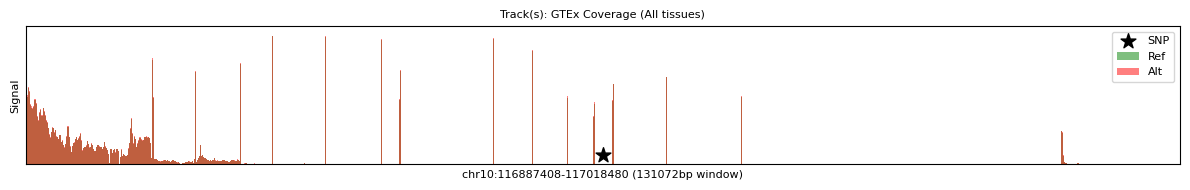

 - sum_wt = 77193.69
 - sum_mut = 93064.84
 - max_y_wt = 696.2884
 - max_y_mut = 837.6076
 -- (max_y = 837.6076)


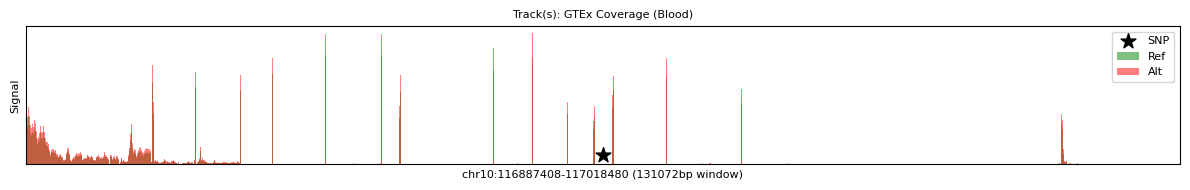

 - sum_wt = 45951.043
 - sum_mut = 46931.766
 - max_y_wt = 425.3462
 - max_y_mut = 430.3084
 -- (max_y = 430.3084)


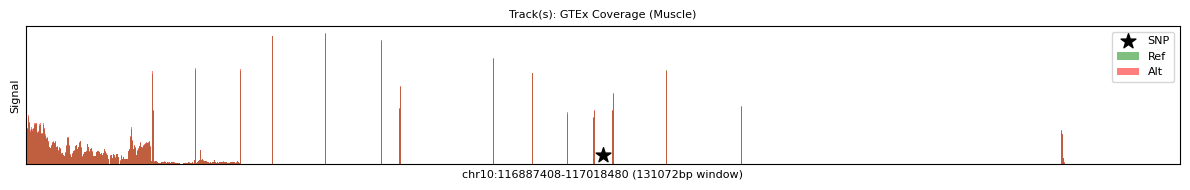

In [14]:
#Visualize quantized tracks over SNP
plot_window = 131072
bin_size = 32
pad = 16

untransform_old = True
normalize_counts = False

anno_df = None #splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [9, 10, 11],
    [47, 48, 49],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Blood)',
    'GTEx Coverage (Muscle)',
]

track_scales = [0.01]*3
track_transforms = [3./4.]*3
soft_clips = [384.]*3

print("-- Counts --")
plot_coverage_track_pair_bins(
    y_wt,
    y_mut,
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=1 * plot_window,
    bin_size=bin_size,
    pad=pad,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
    untransform_old=untransform_old,
)

In [8]:
# Save the descriptions to a CSV file
targets_df['description'].to_csv("/camp/home/wilkino/home/POSTDOC/borzoi/borzoi/jenna/track_descriptions.csv", index=False, header=False)

In [9]:
def one_hot_mut(sequence_one_hot_wt, poses, alts, start):
    sequence_one_hot_mut = np.copy(sequence_one_hot_wt)
    
    for pos, alt in zip(poses, alts):
        alt_ix = -1
        if alt == 'A' :
            alt_ix = 0
        elif alt == 'C' :
            alt_ix = 1
        elif alt == 'G' :
            alt_ix = 2
        elif alt == 'T' :
            alt_ix = 3

        sequence_one_hot_mut[pos-start-1] = 0.
        sequence_one_hot_mut[pos-start-1, alt_ix] = 1.
    return sequence_one_hot_mut

In [22]:
# We need a file that stores everything. Or we can make new files each time that save additional lines 
# each time, but never overwrite the previous. That sounds safer.
import glob

results_directory = "/camp/home/wilkino/home/POSTDOC/borzoi/borzoi/jenna/results_files/"
all_results_files = glob.glob(results_directory + "*results.csv")

#print(all_results_files)

dfs = []
for file in all_results_files:
    df = pd.read_csv(file)  # Read each CSV file
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)
# Keep only rows where the score is unique (appears only once)
merged_df = merged_df[~merged_df['score'].duplicated(keep=False)]


# FILTER FOR CERTAIN REGION
region_to_filter_for = 166127870
region_size = 500

#print(merged_df.iloc[:, 0])

def is_close_to_target(val):
    try:
        first_mut = str(val).split(';')[0][:-1]  # "166127880C" → "166127880"
        num = int(first_mut)
#         print(num)
        return abs(num - region_to_filter_for) < region_size
    except Exception:
        return False

merged_df = merged_df[merged_df['mutations'].apply(is_close_to_target)]

# The dataframe has a two columns - mutations and score

# The mutations column is itself a semi-colon separated list of all mutations for this sequence. 
# eg 1824T;81324714G;234234C

# Specify the number of top scores you want to keep
N = 1  # For example, top 10 scores

# Sort and select the top N rows based on the 'score' column
top_n_df = merged_df.nlargest(N, 'score')

top_n_df = pd.concat([top_n_df, pd.DataFrame([{'mutations': "", 'score': -1}])], ignore_index=True)

# Show the filtered DataFrame
print(top_n_df)

                                           mutations       score
0  166127880C;166127876T;166127868G;166127885G;16...  2338.07963
1                                                       -1.00000


In [24]:
top_n_df = merged_df.nsmallest(N, 'score')
print(top_n_df)

                  mutations       score
6824  166127502C;166127500G  1428.63907


In [20]:
import numpy as np
for mutations, score in zip(top_n_df["mutations"], top_n_df["score"]): 
    
#     if mutations != "":
#         continue
    
    this_attempts_results = {}
    
    # 1. read in mutations
    if mutations != "":
        mutations_d = {int(a[:-1]): a[-1]  for a in mutations.split(";")}
    else:
        mutations_d = {}
    
    # 2. add the mutations and one hot encode
    sequence_one_hot = process_sequence(fasta_open, chrom, start, end)  # this is the WT sequence
    
    for pos, nt in mutations_d.items():
        sequence_one_hot = one_hot_mut(sequence_one_hot, [pos], [nt], start)
        
        # Map index to base: A=0, C=1, G=2, T=3
        bases = np.array(['A', 'C', 'G', 'T'])

        # Find index of 1 in each row and map to base
        sequence = ''.join(bases[np.argmax(sequence_one_hot, axis=1)])
        import gzip
        with gzip.open("/camp/home/wilkino/home/POSTDOC/borzoi/borzoi/jenna/results_files/" + mutations + "_decoded_sequence.txt.gz", "wb") as f:
            f.write(sequence.encode())
        
    # Predict
    y = predict_tracks(models, sequence_one_hot)
    
    # Save to a dataframe for visualisation and analysis in R
    y_np = y.squeeze()
    
    # Convert to DataFrame
    df = pd.DataFrame(y_np)

    # Save as a compressed CSV that R can read easily
    df.to_csv("/camp/home/wilkino/home/POSTDOC/borzoi/borzoi/jenna/results_files/output_dataframes/" + mutations + "_output.csv.gz", index=False, compression="gzip")

In [36]:


y.shape



# Convert to DataFrame
df = pd.DataFrame(y_np)

# Save as a compressed CSV that R can read easily
df.to_csv("/camp/home/wilkino/home/POSTDOC/borzoi/borzoi/jenna/results_files/result_df_wt.csv.gz", index=False, compression="gzip")

In [21]:
# Map index to base: A=0, C=1, G=2, T=3
bases = np.array(['A', 'C', 'G', 'T'])

# Find index of 1 in each row and map to base
sequence = ''.join(bases[np.argmax(sequence_one_hot, axis=1)])
import gzip
with gzip.open("/camp/home/wilkino/home/POSTDOC/borzoi/borzoi/jenna/results_files/decoded_sequence.txt.gz", "wb") as f:
    f.write(sequence.encode())

In [34]:
print(top_n_df['mutations'].iloc[0])

166127880C;166127876T;166127868G;166127885G;166127883C;166127887C;166127884T
